In [188]:
import mne
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import pickle
sys.path.insert(1, os.path.realpath(os.path.pardir))
from LFCNN_decoder import SpatialParameters, TemporalParameters, WaveForms, Predictions, ComponentsOrder
import matplotlib.gridspec as gridspec
from lfcnn_vis import plot_patterns
from GUI import info_pick_channels
from matplotlib.patches import Rectangle, ConnectionPatch
import itertools
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm as cm
import matplotlib.colors as mc

In [10]:
def read_pkl(fname):
    with open(fname, 'rb') as f:
        return pickle.load(f)


def validate_arrays(array1, array2):
    if array1.shape[0] > array2.shape[0]:
        min_len = min(array1.shape[0], array2.shape[0])
        array1 = array1[:min_len]
        array2 = array2[:min_len]
    if array1.shape[1] > array2.shape[1]:
        min_len = min(array1.shape[1], array2.shape[1])
        array1 = array1[:, :min_len]
        array2 = array2[:, :min_len]
    if array1.shape[2] > array2.shape[2]:
        min_len = min(array1.shape[2], array2.shape[2])
        array1 = array1[:, :, :min_len]
        array2 = array2[:, :, :min_len]
    return array1, array2


def process_subject(subjects_dir, model_name, classification_name, sessions, subject):
    subject_path = os.path.join(subjects_dir, subject)
    info_path = os.path.join(subject_path, 'Info')
    info = read_pkl(os.path.join(info_path, os.listdir(info_path)[0]))
    info = info_pick_channels(
        info,
        list(
            filter(
                lambda ch_name: (ch_name[-1] == '2' or ch_name[-1] == '3') and 'meg' in ch_name.lower(),
                info['ch_names']
            )
        )
    )
    train_session = f'train_{sessions[0]}'
    test_sessions = [f'test_{session}' for session in sessions]
    model_data_path = os.path.join(subject_path, f'{model_name}_{train_session}')
    parameters_path = os.path.join(model_data_path, 'Parameters')
    datapaths_pair = [
        f'{classification_name}_{train_session}_{test_session}'
        for test_session in test_sessions
    ]
    waves_data_pair = {
        session: read_pkl(os.path.join(parameters_path, f'{path}_waveforms.pkl'))
        for path, session in zip(datapaths_pair, test_sessions)
    }
    patterns_data_pair = {
        session: read_pkl(os.path.join(parameters_path, f'{path}_spatial.pkl'))
        for path, session in zip(datapaths_pair, test_sessions)
    }

    return info, waves_data_pair, patterns_data_pair

def plot_sescomp(t_obs, times, cluster_ranges, patterns_data_pair, waves_data_pair, info, best_pattern, best_pattern_time, session1, session2, subject):
    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(16, 20)
    ax1 = fig.add_subplot(gs[:4, :])
    ax2 = fig.add_subplot(gs[5:9, :])
    ax3 = fig.add_subplot(gs[10:, :10])
    ax4 = fig.add_subplot(gs[10:, 10:])

    ax1.imshow(t_obs, aspect='auto', cmap='RdBu_r', origin='lower', extent=[times[0], times[-1], 0, t_obs.shape[0]])
    ax1.set_ylabel('Component')
    ax1.set_xlabel('Time (s)')

    if best_pattern:
        condition1 = waves_data_pair[session1]
        condition2 = waves_data_pair[session2]
        condition1, condition2 = validate_arrays(condition1, condition2)

        diff = condition1.mean(axis=0) - condition2.mean(axis=0)
        ax2.imshow(
            diff,
            aspect='auto',
            cmap='RdBu_r',
            origin='lower',
            extent=[times[0], times[-1], 0, t_obs.shape[0]],
        )
        ax2.set_ylabel('Component')
        ax2.set_xlabel('Time (s)')
        cluster_ranges[cluster_ranges == 1] = np.nan
        ax2.imshow(cluster_ranges, aspect='auto', cmap='binary', vmin=0, origin='lower', extent=[times[0], times[-1], 0, t_obs.shape[0]])
        _ = plot_patterns(
            patterns_data_pair[session1].patterns,
            info, best_pattern,
            axes=ax3,
            show=False,
            name_format=f'{session1}'
        )
        _ = plot_patterns(patterns_data_pair[session2].patterns, info, best_pattern, axes=ax4, show=False, name_format=session2)
        fig.suptitle(f'subject: {subject}\ncomponent: {best_pattern}\ntime: {best_pattern_time[0]:.3f} - {best_pattern_time[-1]:.3f} s', y=1.05)
    else:
        fig.suptitle(f'subject: {subject}')

    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=10)

    return fig

In [6]:
subjects_dir = '../Source/Subjects/'
model_name = 'LFCNN'
classification_name = 'RM_vs_RI_vs_LM_vs_LI'
sessions = ['B1-B3', 'B10-B12']
subject = 'Ga_Fed'

info, waves_data_pair, patterns_data_pair = process_subject(subjects_dir, model_name, classification_name, sessions, subject)
session1, session2 = waves_data_pair.keys()
waves_data_pair_np = {
    k: np.squeeze(v.tcs)
    for k, v in waves_data_pair.items()
}

test_data = list()
for n_latent in range(waves_data_pair_np[session1].shape[-1]):
    data1 = waves_data_pair_np[session1][:, :, n_latent]
    data2 = waves_data_pair_np[session2][:, :, n_latent]
    if len(data1) != len(data2):
        min_len = min(len(data1), len(data2))
        data1 = data1[:min_len]
        data2 = data2[:min_len]

    threshold = 6.0
    # T_obs, clusters, cluster_p_values, H0
    test_data.append(mne.stats.permutation_cluster_test(
        [data1, data2],
        n_permutations=10000,
        threshold=threshold,
        tail=1,
        n_jobs=None,
        out_type="mask",
    ))

cluster_ranges = list()
t_obs = list()
times = waves_data_pair[session1].times - 0.5 + 60/200
highest_t_obs_val = -1e-7
best_pattern = None
best_pattern_time = None
for n_latent in range(waves_data_pair_np[session1].shape[-1]):
    T_obs, clusters, cluster_p_values, H0 = test_data[n_latent]
    t_obs.append(T_obs)
    cluster_range = np.zeros_like(times)

    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:
            cluster_range[c.start : c.stop - 1] = 1
            t_obs_val = T_obs[c.start : c.stop - 1].sum()
            if t_obs_val > highest_t_obs_val:
                highest_t_obs_val = t_obs_val
                best_pattern = n_latent
                best_pattern_time = times[c.start : c.stop - 1]

    cluster_ranges.append(cluster_range)

cluster_ranges = np.array(cluster_ranges)
t_obs = np.array(t_obs)

# fig = plot_sescomp(t_obs, times, cluster_ranges, patterns_data_pair, waves_data_pair_np, info, best_pattern, best_pattern_time, session1, session2, subject)
# plt.show()


NameError: name 'process_subject' is not defined

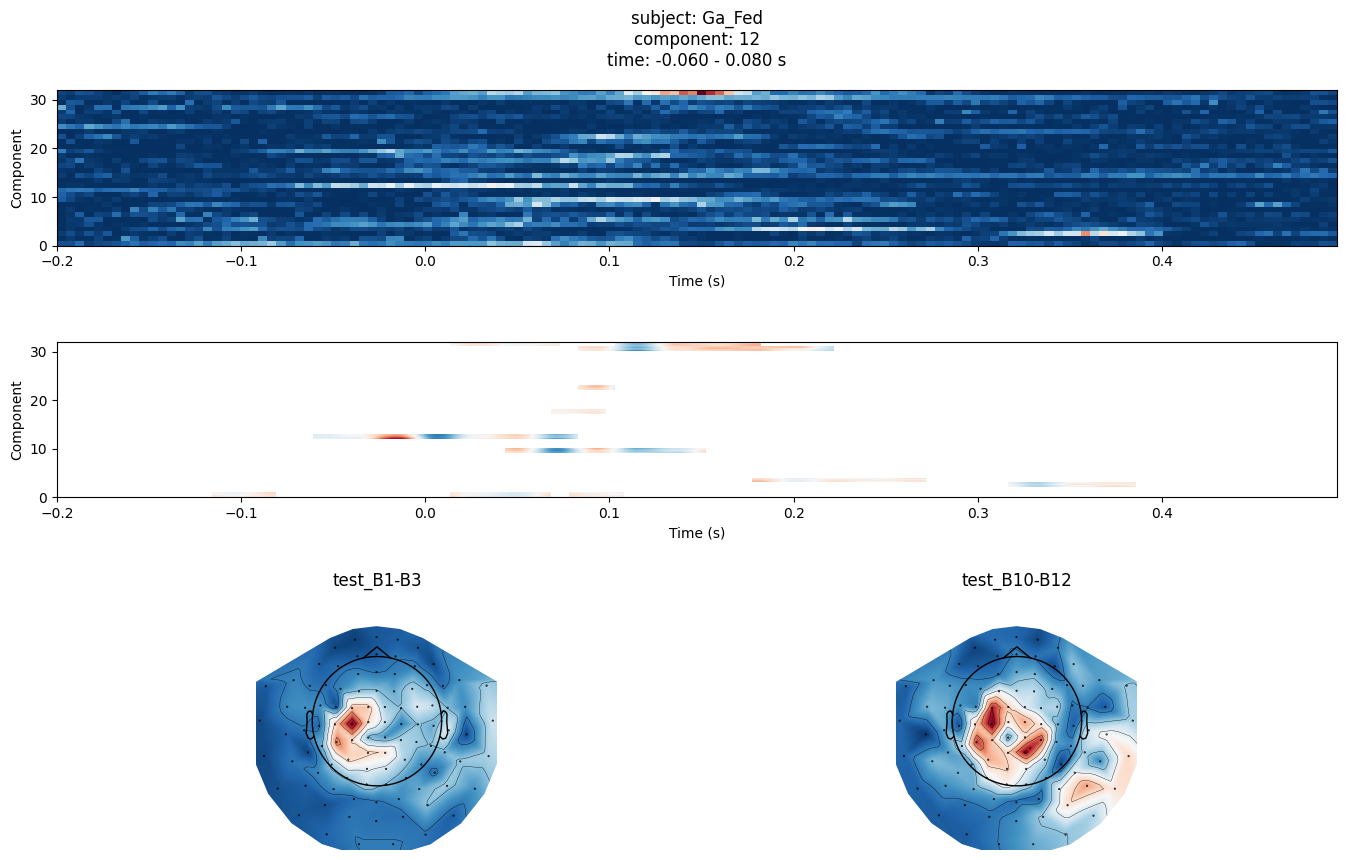

In [96]:

fig = plot_sescomp(t_obs, times, cluster_ranges, patterns_data_pair, waves_data_pair_np, info, best_pattern, best_pattern_time, session1, session2, subject)
plt.show()

In [64]:
condition1 = waves_data_pair_np[session1]
condition2 = waves_data_pair_np[session2]
condition1, condition2 = validate_arrays(condition1, condition2)

diff = condition1.mean(axis=0) - condition2.mean(axis=0)
dirs_map = np.sign((diff.T * cluster_ranges))
pos_dirs_map = dirs_map.copy()
pos_dirs_map[dirs_map < 0] = 0
neg_dirs_map = dirs_map.copy()
neg_dirs_map[dirs_map > 0] = 0
neg_dirs_map = - neg_dirs_map

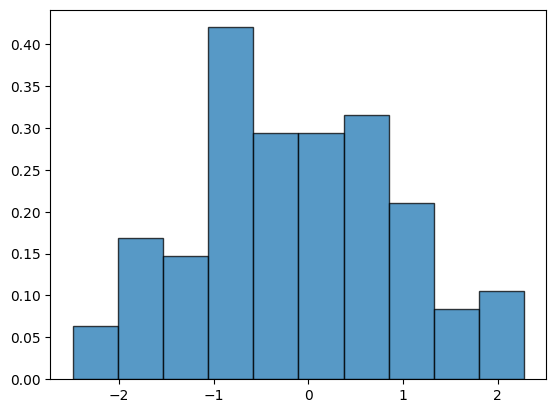

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, bins=10, axis=None, **kwargs) -> plt.Figure:
    """
    Plot a histogram of the input data.

    Parameters:
    - data: 1-dimensional NumPy array of float values.
    - bins: Number of bins for the histogram.
    - axis: (Optional) Matplotlib axis object. If provided, the histogram will be plotted on this axis.
            If not provided, a new figure and axis will be created.
    - **kwargs: Additional keyword arguments to be passed to the axis.hist() function.

    Returns:
    - If axis is provided, returns nothing.
    - If axis is not provided, returns the figure and axis objects.
    """
    if axis is None:
        # Create a new figure and axis
        fig, axis = plt.subplots(**kwargs)

    # Plot the histogram
    axis.hist(data, bins=bins, alpha=0.75, edgecolor='black', density=True)

    if axis is None:
        return fig, axis

data = np.random.normal(0, 1, 100)

# Plot the histogram using the function
plot_histogram(data, bins=10)

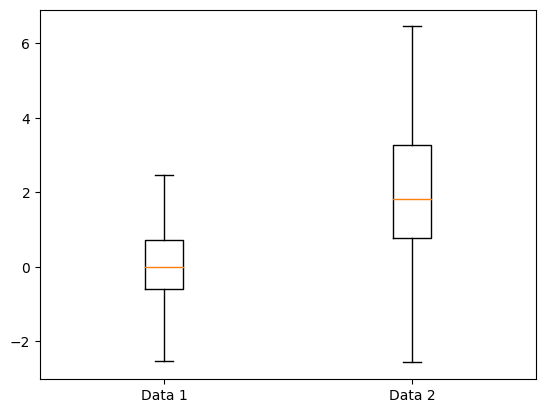

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_boxplot(data1, data2, labels=None, axis=None, **kwargs) -> plt.Figure:
    """
    Plot side-by-side boxplots for two sets of data.

    Parameters:
    - data1: 1-dimensional NumPy array of float values for the first dataset.
    - data2: 1-dimensional NumPy array of float values for the second dataset.
    - labels: (Optional) List of two labels for the datasets. If provided, these labels will be used for the x-axis tick labels.
    - axis: (Optional) Matplotlib axis object. If provided, the boxplots will be plotted on this axis.
            If not provided, a new figure and axis will be created.
    - **kwargs: Additional keyword arguments to be passed to the axis.boxplot() function.

    Returns:
    - If axis is provided, returns nothing.
    - If axis is not provided, returns the figure and axis objects.
    """
    if axis is None:
        # Create a new figure and axis
        fig, axis = plt.subplots(**kwargs)
    else:
        fig = None

    # Create a list of data for boxplot
    boxplot_data = [data1, data2]

    # Plot the boxplots
    axis.boxplot(boxplot_data, labels=labels)

    if axis is None:
        return fig, axis

# Example usage:
data1 = np.random.normal(0, 1, 100)
data2 = np.random.normal(2, 2, 100)
plot_boxplot(data1, data2, labels=["Data 1", "Data 2"])
plt.show()


In [11]:
np.corrcoef(np.random.normal(0, 1, 100), np.random.normal(0, 1, 100))[0, 1]

0.1136894179684221

In [72]:
patterns_data_pair[session1].patterns.shape

(204, 32)

In [70]:
pos_dirs_map.sum(0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [69]:
neg_dirs_map.sum(0)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3., 3., 4., 4.,
       4., 4., 4., 4., 3., 4., 4., 4., 4., 3., 4., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [32]:
directionss = np.sign((diff.T * cluster_ranges))


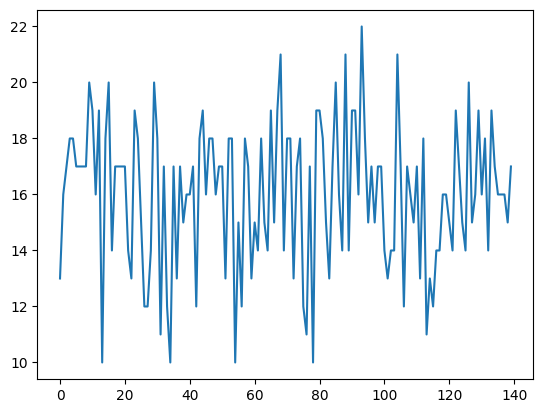

In [119]:
plt.plot(np.random.randint(0, 2, cluster_ranges.shape).sum(axis=0))

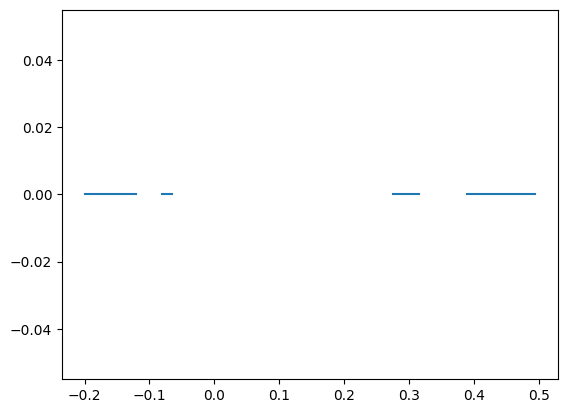

In [116]:
cluster_ranges_row = cluster_ranges.sum(axis=0)
plt.plot(times, cluster_ranges_row)

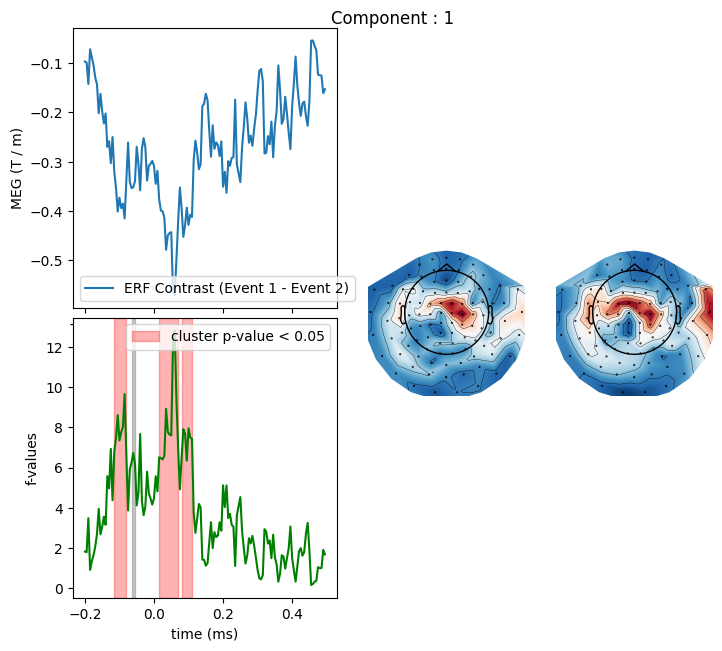

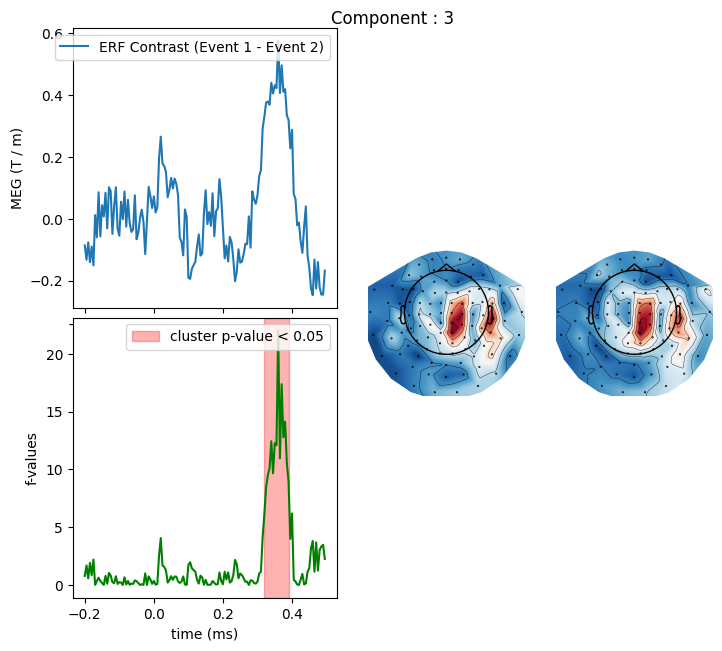

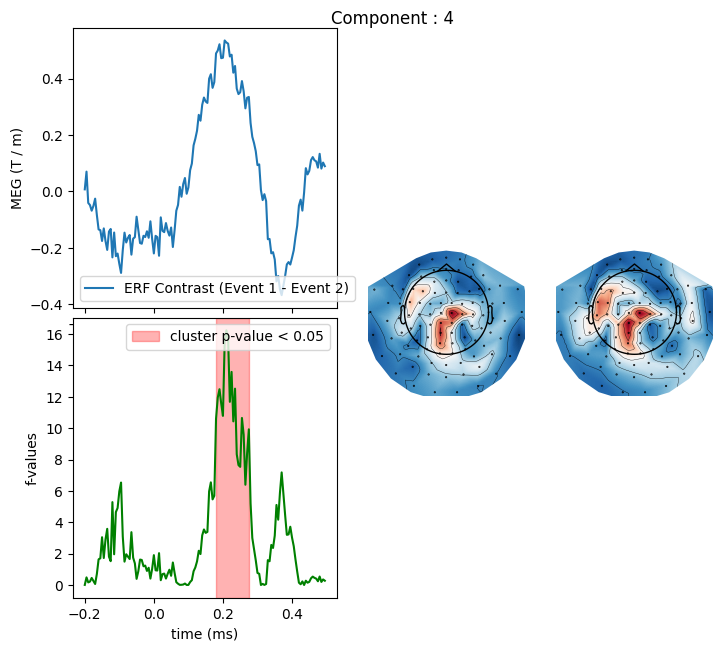

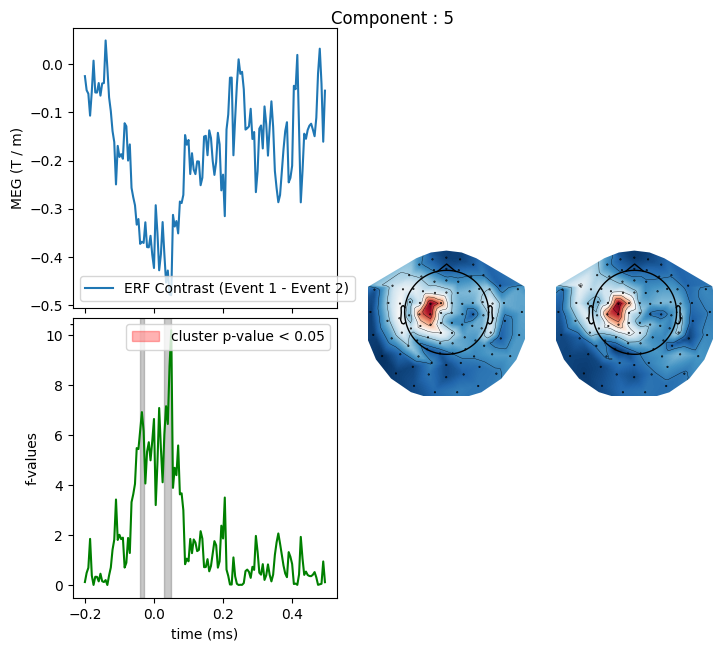

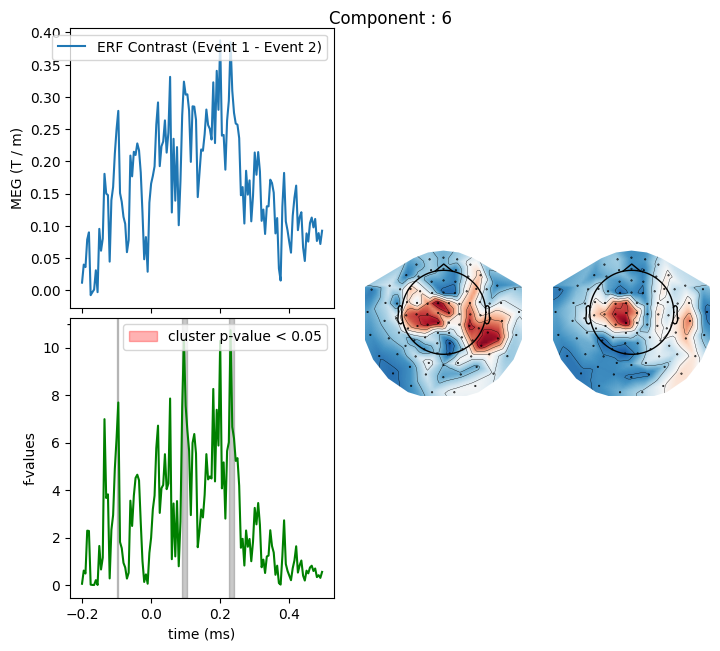

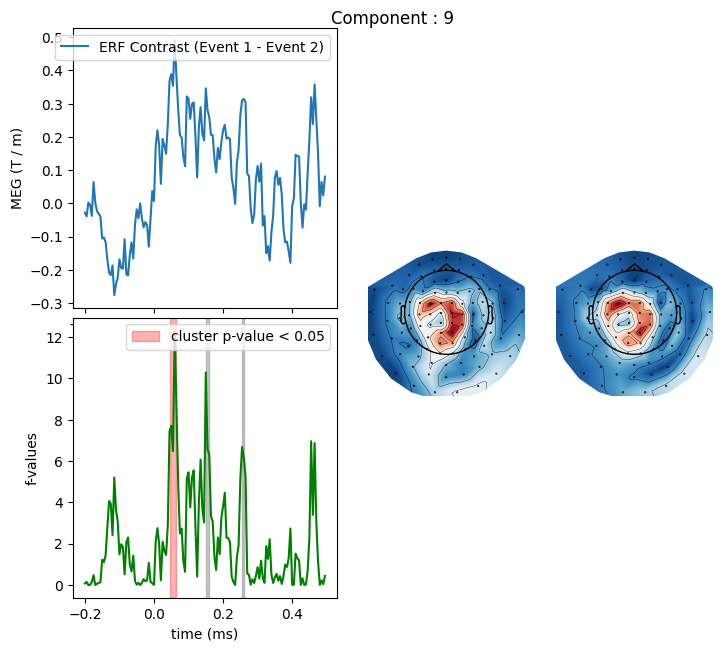

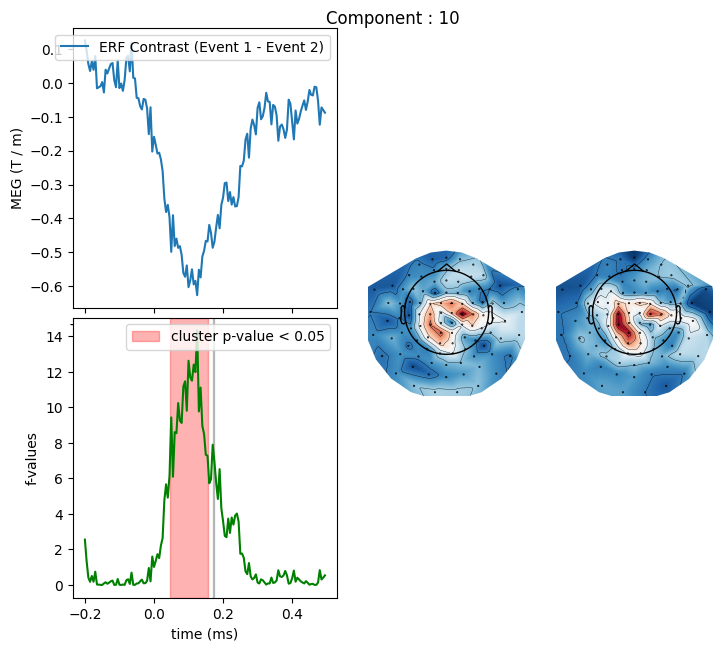

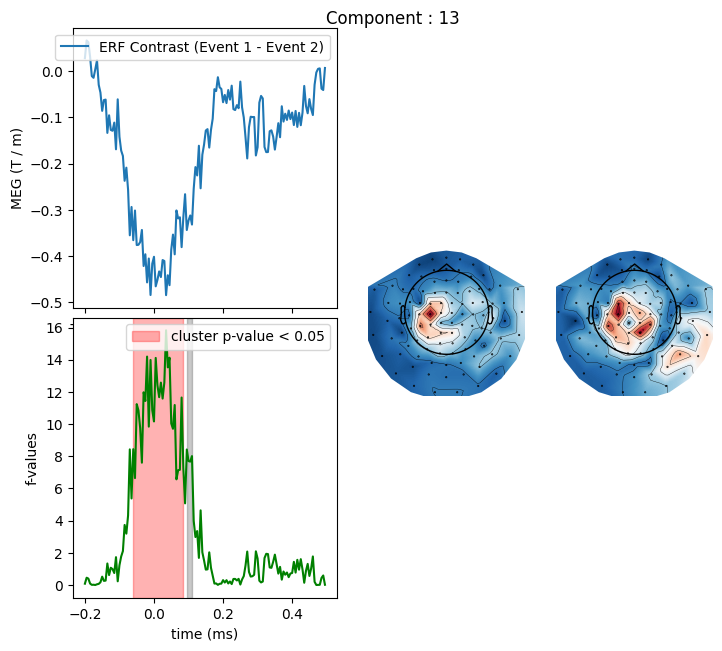

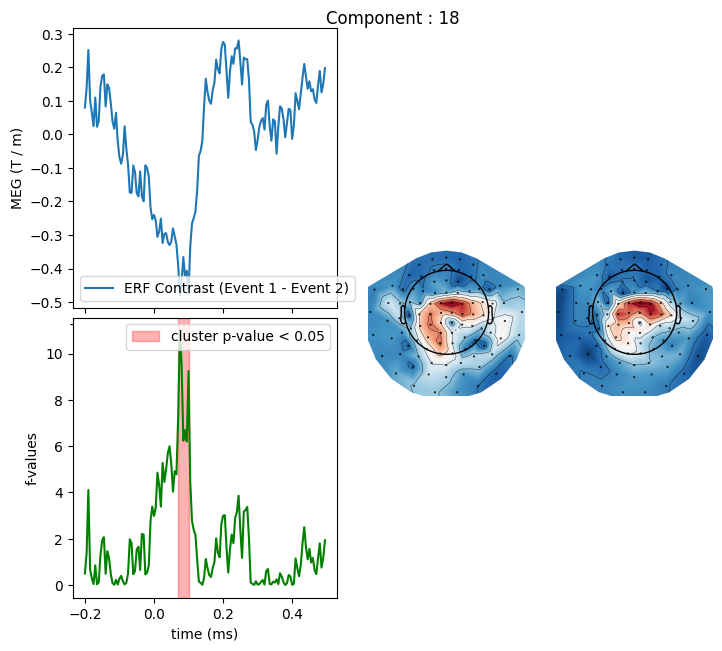

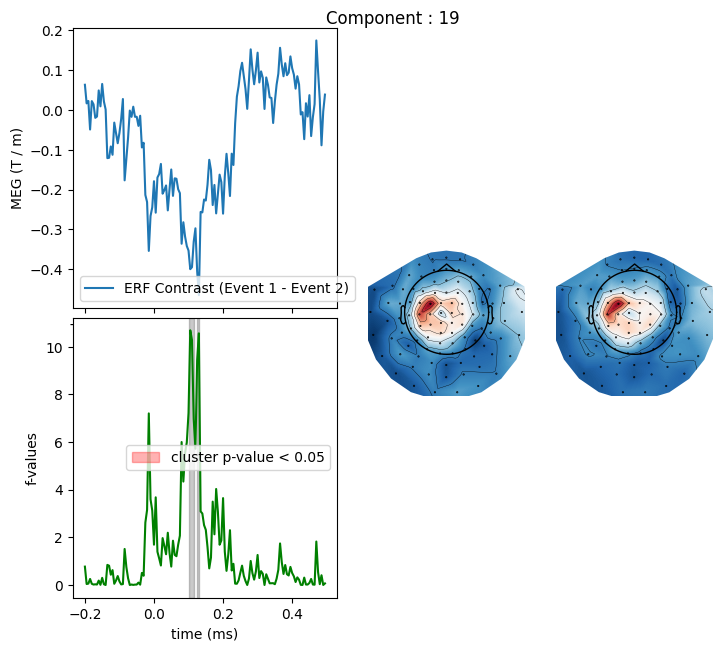

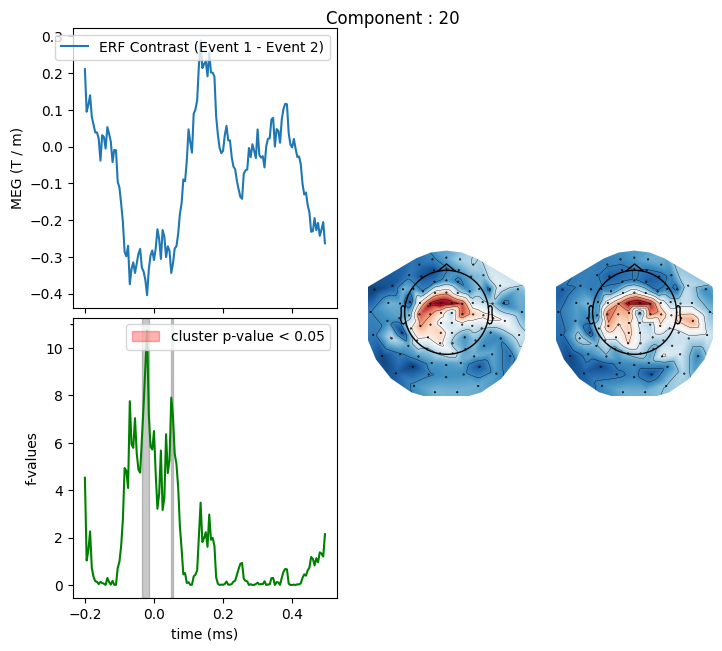

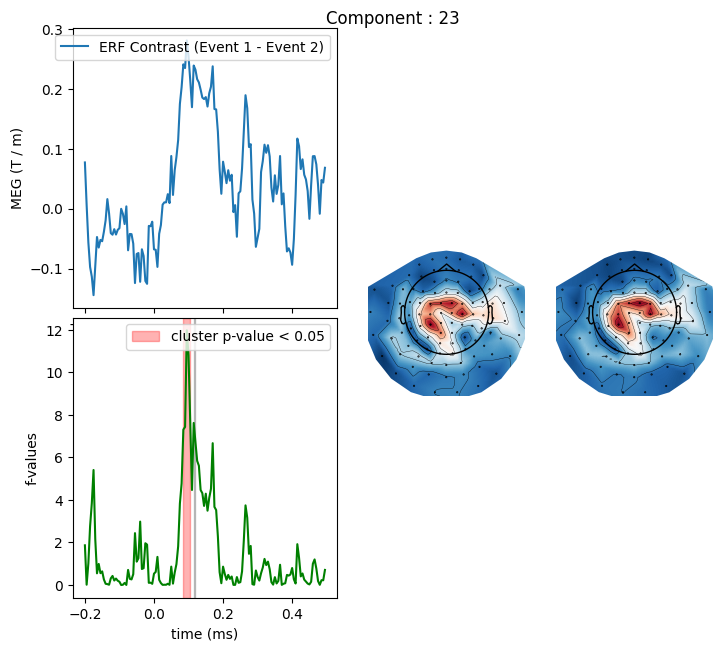

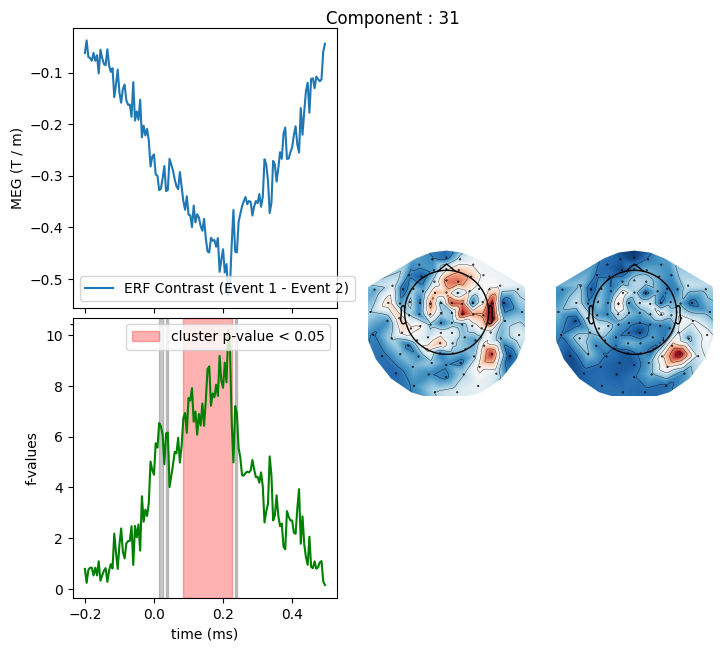

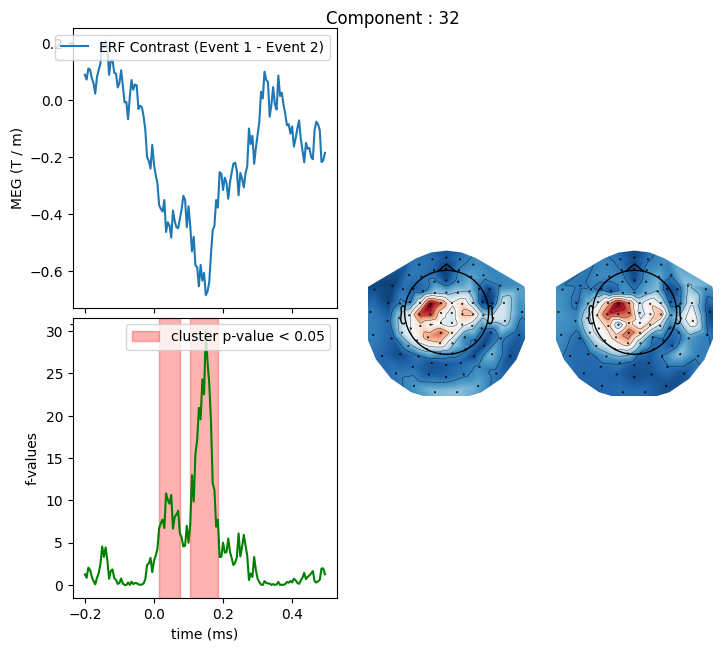

In [154]:
times = waves_data_pair['test_B1-B3'].times - 0.5 + 60/200

for n_latent in range(waves_data_pair_np['test_B1-B3'].shape[-1]):
    T_obs, clusters, cluster_p_values, H0 = test_data[n_latent]
    c_sizes = [c[0].stop - 1 - c[0].start for c in clusters]

    if len(cluster_p_values) and any([size > 1 for size in c_sizes]):
        # fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
        fig = plt.figure(figsize=(8, 6))

        gs = gridspec.GridSpec(10, 24)

        ax1 = fig.add_subplot(gs[:5, 0:10])
        ax2 = fig.add_subplot(gs[5:, 0:10])
        ax3 = fig.add_subplot(gs[:, 11:17])
        ax4 = fig.add_subplot(gs[:, 18:24])
        fig.suptitle(f"Component : {n_latent + 1}")
        session1, session2 = test_sessions
        condition1 = waves_data_pair_np[session1][:, :, n_latent]
        condition2 = waves_data_pair_np[session2][:, :, n_latent]
        ax1.plot(
            times,
            condition1.mean(axis=0) - condition2.mean(axis=0),
            label="ERF Contrast (Event 1 - Event 2)",
        )
        ax1.set_ylabel("MEG (T / m)")
        ax1.legend()

        for i_c, c in enumerate(clusters):
            c = c[0]
            if c.stop - 1 - c.start < 1:
                continue
            if cluster_p_values[i_c] <= 0.05:
                h = ax2.axvspan(times[c.start], times[c.stop - 1], color="r", alpha=0.3)
            else:
                ax2.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3), alpha=0.3)

        hf = ax2.plot(times, T_obs, "g")
        ax2.legend((h,), ("cluster p-value < 0.05",))
        ax2.set_xlabel("time (ms)")
        ax2.set_ylabel("f-values")
        # plt.show()
        # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        _ = plot_patterns(patterns_data_pair[session1].patterns, info, n_latent, axes=ax3, show=False, name_format='')
        _ = plot_patterns(patterns_data_pair[session2].patterns, info, n_latent, axes=ax4, show=False, name_format='')
        plt.show()

In [3]:
import math

def lcm_list(numbers):
    # Ensure the list is not empty
    if not numbers:
        return None

    # Initialize the result as the first number in the list
    result = numbers[0]

    # Iterate through the list and calculate the LCM of each number with the result
    for num in numbers[1:]:
        result = (result * num) // math.gcd(result, num)

    return result


def generate_slices(numbers):
    lcm = lcm_list(numbers)
    slices = list()

    for number in numbers:
        slices.append(range(0, lcm + 1, lcm // number))

    slices = list(
        map(
            lambda slice_: [slice(start, end) for start, end in zip(slice_[:-1], slice_[1:])],
            slices
        )
    )

    return slices


def count_nested_lists(lst):

    nested_count = 0
    for elem in lst:
        if isinstance(elem, list):
            nested_count += 1
    return nested_count


def get_grid(template: list[tuple[int, int]] = 4, figsize: tuple[int, int] = (16, 8)) -> tuple[plt.Figure, list[plt.Axes], list[plt.Axes]]:
    if isinstance(template, int):
        template = [template]

    rows = [row for row, _ in template ]
    cols = [col for _, col in template]
    n_rows = sum(rows)
    n_cols = lcm_list(cols)

    rows_slices = list()
    start = 0
    for row in rows:
        rows_slices.append(slice(start, start + row))
        start += row

    cols_slices = generate_slices(cols)

    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(n_rows, n_cols)
    axes = list()

    for row, col in zip(rows_slices, cols_slices):
        axes.append([fig.add_subplot(gs[row, col]) for col in col])

    return fig, axes


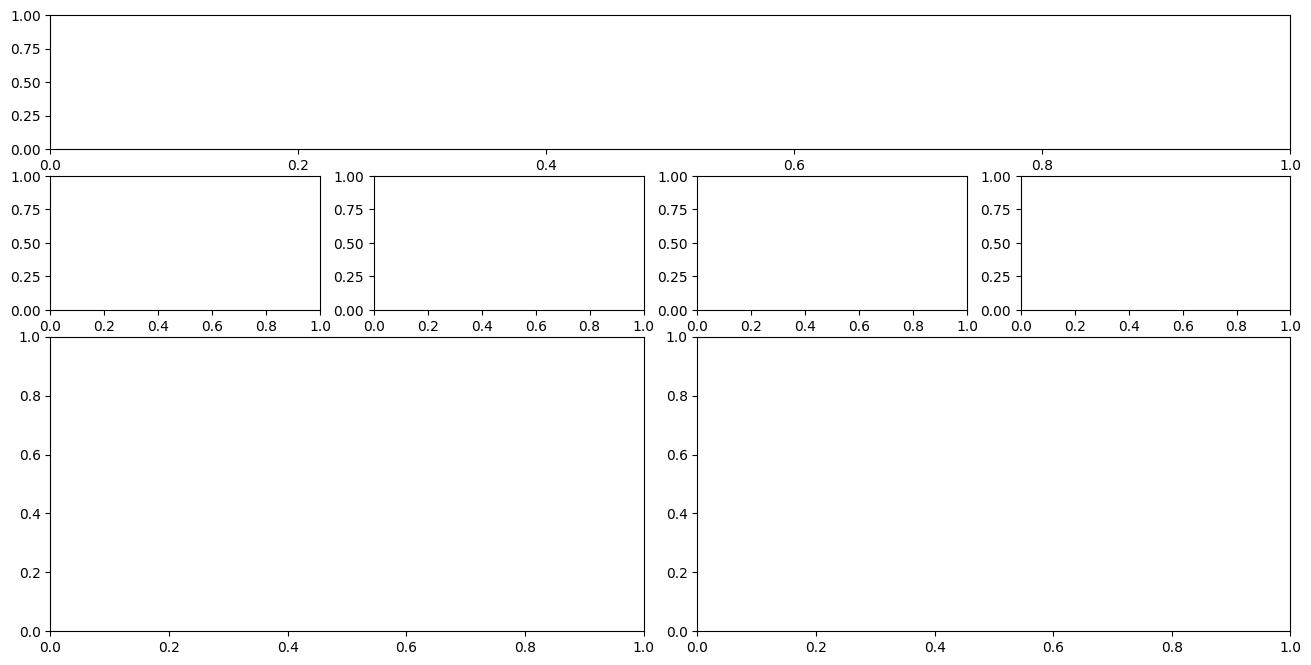

In [9]:
fig, axes = get_grid(
    template=[
        (1, 1),
        (1, 4),
        (2, 2)
    ]
)


In [50]:
(2 + 16 + 1) + (4 + 4 + 4 + 4 + 1) + (2 + 8 + 2 + 8)

56

In [90]:
18 - 4

14

[[<Axes: >], [<Axes: >, <Axes: >, <Axes: >, <Axes: >], [<Axes: >, <Axes: >]]

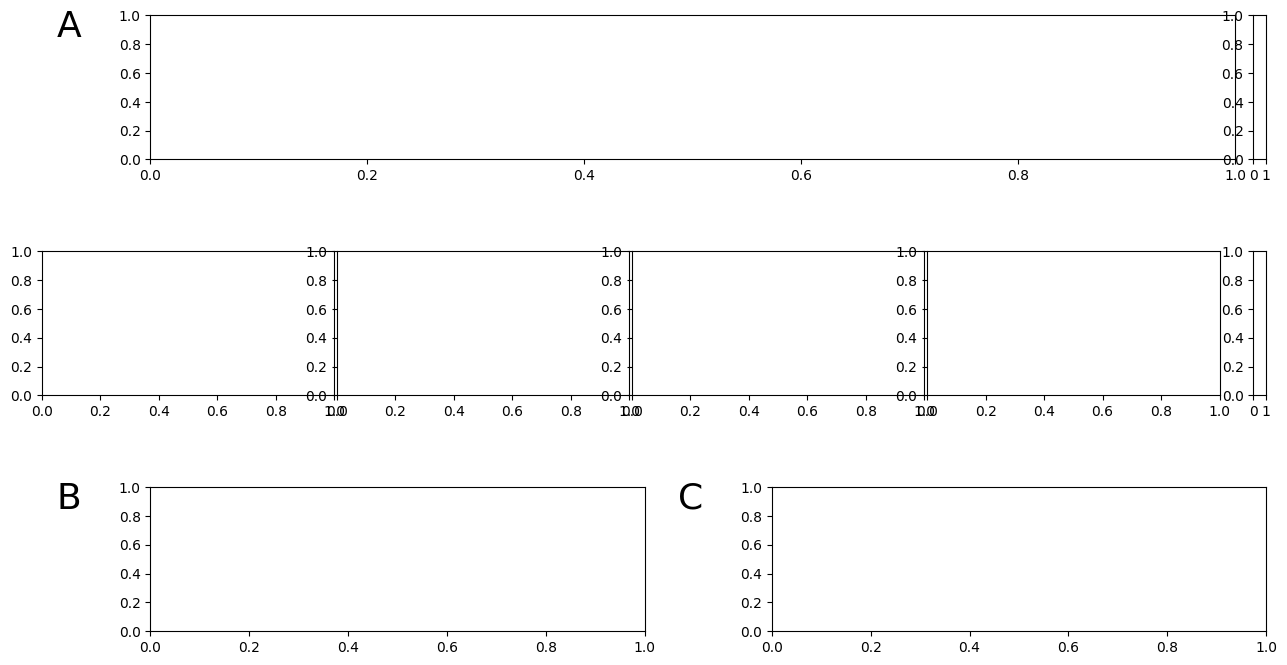

In [177]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(8, 80)

upper_row = [
    fig.add_subplot(gs[0:2, 0:8]),
    fig.add_subplot(gs[0:2, 8:78]),
    fig.add_subplot(gs[0:2, 79:]),
]

middle_row = [
    fig.add_subplot(gs[3:5, 1:20]),
    fig.add_subplot(gs[3:5, 20:39]),
    fig.add_subplot(gs[3:5, 39:58]),
    fig.add_subplot(gs[3:5, 58:77]),
    fig.add_subplot(gs[3:5, -1:]),
]

bottom_row = [
    fig.add_subplot(gs[6:, 0:8]),
    fig.add_subplot(gs[6:, 8:40]),
    fig.add_subplot(gs[6:, 40:48]),
    fig.add_subplot(gs[6:, 48:]),
]

upper_row[0].text(0.25, .85, 'A', fontsize=26)
upper_row[0].axis('off')
bottom_row[0].text(0.25, .85, 'B', fontsize=26)
bottom_row[0].axis('off')
bottom_row[2].text(0.25, .85, 'C', fontsize=26)
bottom_row[2].axis('off')
#[[<Axes: >], [<Axes: >, <Axes: >, <Axes: >, <Axes: >], [<Axes: >, <Axes: >]]
axes = [
    upper_row[:1],
    middle_row[:-1],
    bottom_row[1::2]
]
axes

In [12]:
subjects_dir = '../Source/Subjects/'
model_name = 'LFCNN'
classification_name = 'RM_vs_RI_vs_LM_vs_LI'
sessions = ['B1-B3', 'B10-B12']
subject = 'Ga_Fed'

info, waves_data_pair, patterns_data_pair = process_subject(subjects_dir, model_name, classification_name, sessions, subject)
session1, session2 = waves_data_pair.keys()
waves_data_pair_np = {
    k: np.squeeze(v.tcs)
    for k, v in waves_data_pair.items()
}

test_data = list()
for n_latent in range(waves_data_pair_np[session1].shape[-1]):
    data1 = waves_data_pair_np[session1][:, :, n_latent]
    data2 = waves_data_pair_np[session2][:, :, n_latent]
    if len(data1) != len(data2):
        min_len = min(len(data1), len(data2))
        data1 = data1[:min_len]
        data2 = data2[:min_len]

    threshold = 6.0
    # T_obs, clusters, cluster_p_values, H0
    test_data.append(mne.stats.permutation_cluster_test(
        [data1, data2],
        n_permutations=10000,
        threshold=threshold,
        tail=1,
        n_jobs=None,
        out_type="mask",
    ))

cluster_ranges = list()
t_obs = list()
times = waves_data_pair[session1].times - 0.5 + 60/200
highest_t_obs_val = -1e-7
best_patterns = [None, None]
best_pattern_times = [None, None]
for n_latent in range(waves_data_pair_np[session1].shape[-1]):
    T_obs, clusters, cluster_p_values, H0 = test_data[n_latent]
    t_obs.append(T_obs)
    cluster_range = np.zeros_like(times)

    for i_c, c in enumerate(clusters):
        c = c[0]
        if cluster_p_values[i_c] <= 0.05:
            cluster_range[c.start : c.stop - 1] = 1
            t_obs_val = T_obs[c.start : c.stop - 1].sum()
            if t_obs_val > highest_t_obs_val:
                highest_t_obs_val = t_obs_val
                best_patterns[0], best_patterns[1] = n_latent, best_patterns[0]
                best_pattern_times[0], best_pattern_times[1] = times[c.start : c.stop - 1], best_pattern_times[0]

    cluster_ranges.append(cluster_range)

cluster_ranges = np.array(cluster_ranges)
t_obs = np.array(t_obs)

# fig = plot_sescomp(t_obs, times, cluster_ranges, patterns_data_pair, waves_data_pair_np, info, best_pattern, best_pattern_time, session1, session2, subject)
# plt.show()


stat_fun(H1): min=0.165183 max=12.822347
Running initial clustering …
Found 6 clusters


/tmp/ipykernel_1552749/2423492764.py:3: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  return pickle.load(f)
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 7435.95it/s]


stat_fun(H1): min=0.000015 max=6.318312
Running initial clustering …
Found 1 cluster


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6399.85it/s]


stat_fun(H1): min=0.000306 max=22.028664
Running initial clustering …
Found 2 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6239.59it/s]


stat_fun(H1): min=0.000599 max=16.237497
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6798.85it/s]


stat_fun(H1): min=0.003402 max=10.180216
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 7197.88it/s]

stat_fun(H1): min=0.000382 max=10.734632
Running initial clustering …
Found 10 clusters



100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6725.28it/s]

stat_fun(H1): min=0.000819 max=5.068014
Running initial clustering …
Found 0 clusters


stat_fun(H1): min=0.000001 max=5.104270
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(


stat_fun(H1): min=0.000001 max=12.332140
Running initial clustering …
Found 6 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6081.37it/s]


stat_fun(H1): min=0.000213 max=14.332767
Running initial clustering …
Found 3 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 8225.34it/s]


stat_fun(H1): min=0.000191 max=3.628041
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=-0.000000 max=5.086617
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(


stat_fun(H1): min=0.001331 max=15.827883
Running initial clustering …
Found 3 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 7740.35it/s]


stat_fun(H1): min=0.000000 max=3.062440
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=0.009051 max=8.315161
Running initial clustering …
Found 9 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 8003.55it/s]

stat_fun(H1): min=0.000286 max=8.282380
Running initial clustering …
Found 3 clusters



100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6397.10it/s]

stat_fun(H1): min=0.000089 max=4.994675
Running initial clustering …
Found 0 clusters


stat_fun(H1): min=0.005125 max=11.002816
Running initial clustering …
Found 1 cluster


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6303.30it/s]


stat_fun(H1): min=0.000119 max=10.690450
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6380.91it/s]


stat_fun(H1): min=0.000002 max=10.749155
Running initial clustering …
Found 6 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6922.94it/s]


stat_fun(H1): min=0.000002 max=4.254319
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=0.000017 max=5.767237
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(


stat_fun(H1): min=0.000005 max=11.978992
Running initial clustering …
Found 3 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 5888.31it/s]


stat_fun(H1): min=0.000673 max=4.198143
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=0.000004 max=7.272720
Running initial clustering …
Found 2 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6361.11it/s]


stat_fun(H1): min=0.000086 max=4.716570
Running initial clustering …
Found 0 clusters
stat_fun(H1): min=0.000000 max=4.878015
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(


stat_fun(H1): min=0.000062 max=5.314037
Running initial clustering …
Found 0 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(


stat_fun(H1): min=0.000036 max=7.553281
Running initial clustering …
Found 3 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6696.48it/s]

stat_fun(H1): min=0.000006 max=5.756559
Running initial clustering …
Found 0 clusters


stat_fun(H1): min=0.158376 max=10.187838
Running initial clustering …
Found 4 clusters


/tmp/ipykernel_1552749/650899418.py:25: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  test_data.append(mne.stats.permutation_cluster_test(
100%|██████████| Permuting : 9999/9999 [00:01<00:00, 8428.70it/s]


stat_fun(H1): min=0.001396 max=30.107809
Running initial clustering …
Found 4 clusters


100%|██████████| Permuting : 9999/9999 [00:01<00:00, 6687.81it/s]


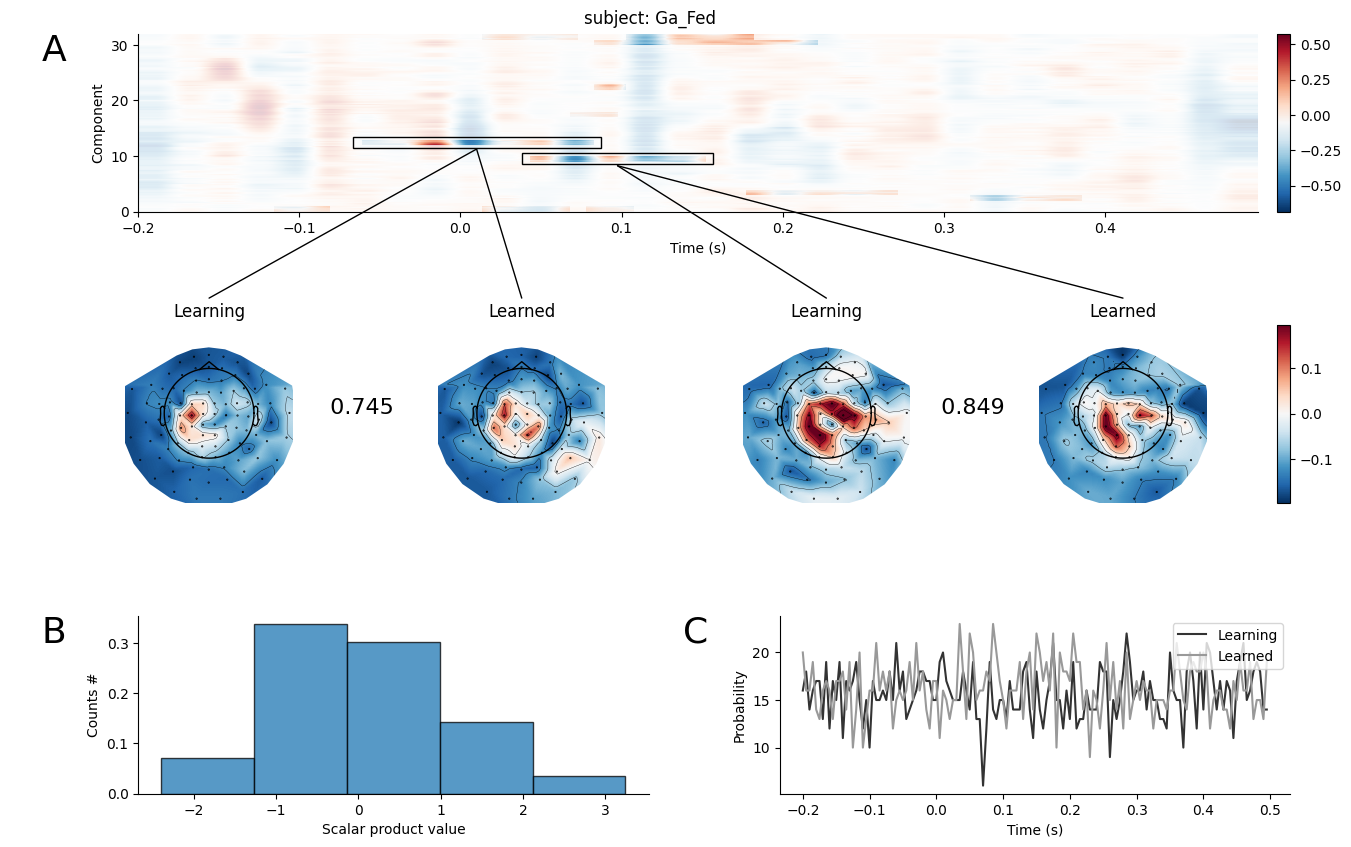

In [222]:

def plot_sescomp(
    t_obs,
    times,
    cluster_ranges,
    patterns_data_pair,
    waves_data_pair,
    info,
    best_patterns,
    best_patterns_time,
    session1,
    session2,
    subject,
    spatial_prob,
    temporal_prob,
):

    fig = plt.figure(figsize=(16, 8))
    gs = gridspec.GridSpec(8, 80)

    upper_row = [
        fig.add_subplot(gs[0:2, 0:8]),
        fig.add_subplot(gs[0:2, 8:78]),
        fig.add_subplot(gs[0:2, 79:]),
    ]

    middle_row = [
        fig.add_subplot(gs[3:5, 3:22]),
        fig.add_subplot(gs[3:5, 22:42]),
        fig.add_subplot(gs[3:5, 42:60]),
        fig.add_subplot(gs[3:5, 60:79]),
        fig.add_subplot(gs[3:5, -1:]),
    ]
    scalar_product_axes = [
        fig.add_subplot(gs[3:5, 3:42]),
        fig.add_subplot(gs[3:5, 42:79]),
    ]

    bottom_row = [
        fig.add_subplot(gs[6:, 0:8]),
        fig.add_subplot(gs[6:, 8:40]),
        fig.add_subplot(gs[6:, 40:48]),
        fig.add_subplot(gs[6:, 48:]),
]

    upper_row[0].text(0.25, .85, 'A', fontsize=26)
    upper_row[0].axis('off')
    bottom_row[0].text(0.25, .85, 'B', fontsize=26)
    bottom_row[0].axis('off')
    bottom_row[2].text(0.25, .85, 'C', fontsize=26)
    bottom_row[2].axis('off')
    axes = [
        upper_row[1:2],
        middle_row[:-1],
        bottom_row[1::2]
    ]
    upper_cax = upper_row[-1]
    middle_cax = middle_row[-1]

    ax2 = axes[0][0]

    if session1 == 'test_B10-B12':
        session1, session2 = session2, session1

    session_to_name = {
        'test_B1-B3': 'Learning',
        'test_B10-B12': 'Learned'
    }

    condition1 = waves_data_pair[session1]
    condition2 = waves_data_pair[session2]
    condition1, condition2 = validate_arrays(condition1, condition2)
    diff = condition1.mean(axis=0) - condition2.mean(axis=0)

    if best_patterns_time[0][-1] > best_patterns_time[1][-1]:
        best_patterns_time[0], best_patterns_time[1] = best_patterns_time[1], best_patterns_time[0]
        best_patterns[0], best_patterns[1] = best_patterns[1], best_patterns[0]

    cb = None
    for i, (best_pattern, best_pattern_time) in enumerate(zip(best_patterns, best_patterns_time)):

        if best_pattern is None:
            continue

        ratio = np.corrcoef(
            patterns_data_pair[session1].patterns[:, best_pattern],
            patterns_data_pair[session2].patterns[:, best_pattern]
        )[0, 1]
        scalar_product_axes[i].text(.425, .5, f'{ratio : .3f}', fontsize=16)
        scalar_product_axes[i].axis('off')

        vlim = (
            0,
            1.1*patterns_data_pair[session1].patterns[:, best_pattern].max(),
        )

        img = ax2.imshow(
            diff,
            aspect='auto',
            cmap='RdBu_r',
            origin='lower',
            extent=[times[0], times[-1], 0, t_obs.shape[0]],
        )

        if cb is None:
            fig.colorbar(img, cax=upper_cax)

        ax2.set_ylabel('Component')
        ax2.set_xlabel('Time (s)')
        cluster_ranges[cluster_ranges == 1] = np.nan
        ax2.imshow(cluster_ranges, aspect='auto', cmap='binary', vmin=0, origin='lower', extent=[times[0], times[-1], 0, t_obs.shape[0]], alpha=.8)
        ax3 = axes[1][i*2]
        ax4 = axes[1][i*2 + 1]
        _ = plot_patterns(
            patterns_data_pair[session1].patterns,
            info, best_pattern,
            axes=ax3,
            show=False,
            name_format=session_to_name[session1],
            vlim=vlim, scalings=1.
        )
        _ = plot_patterns(
            patterns_data_pair[session2].patterns,
            info,
            best_pattern,
            axes=ax4,
            show=False,
            name_format=session_to_name[session2],
            vlim=vlim, scalings=1.,
            colorbar=False
        )
        if i*2 + 1 == 3:
            fig.colorbar(
                cm.ScalarMappable(norm=mc.Normalize(-vlim[-1], vlim[-1]), cmap='RdBu_r'),
                cax=middle_cax
            )

        x_low, x_high = ax2.get_xlim()
        middle_time = (best_pattern_time[0] + best_pattern_time[-1])/2
        time_perc = (middle_time - x_low)/(x_high - x_low)

        con = ConnectionPatch(
            [time_perc, (best_pattern - .75)/patterns_data_pair[session1].patterns.shape[-1] ],
            [.5, 1.15],
            axesA=ax2,
            axesB=ax3,
            coordsA='axes fraction',
            coordsB='axes fraction',
            color='black'
        )
        fig.add_artist(con)
        con = ConnectionPatch(
            [time_perc, (best_pattern - .75)/patterns_data_pair[session1].patterns.shape[-1]],
            [.5, 1.15],
            axesA=ax2,
            axesB=ax4,
            coordsA='axes fraction',
            coordsB='axes fraction',
            color='black'
        )
        fig.add_artist(con)
        rect = Rectangle(
            xy=(best_pattern_time[0] - .01*(times[-1] - times[0]) , best_pattern - .5),
            width = best_pattern_time[-1] - best_pattern_time[0] + 2*.01*(times[-1] - times[0]),
            height=2,#/patterns_data_pair[session1].patterns.shape[-1],
            edgecolor='black',
            facecolor='none'
        )
        ax2.add_patch(rect)
    ax5, ax6 = axes[-1][0], axes[-1][1]
    plot_histogram(spatial_prob, bins=5, axis=ax5)
    ax5.set_xlabel('Scalar product value')
    ax5.set_ylabel('Counts #')
    ax6.plot(times, temporal_prob[0], color='#333', label='Learning')
    ax6.plot(times, temporal_prob[1], color='#999', label='Learned')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('Probability')
    ax6.legend(loc='upper right')

    for ax in list(itertools.chain(*axes)):
        ax.spines[['right', 'top']].set_visible(False)

    fig.suptitle(f'subject: {subject}')#\ncomponent: {best_pattern}\ntime: {best_pattern_time[0]:.3f} - {best_pattern_time[-1]:.3f} s', y=1.05)
    # fig.tight_layout()

    return fig

fig = plot_sescomp(
    t_obs,
    times,
    cluster_ranges,
    patterns_data_pair,
    waves_data_pair_np,
    info,
    best_patterns,
    best_pattern_times,
    session1,
    session2,
    subject,
    np.random.normal(0, 1, 100),
    (np.random.randint(0, 2, cluster_ranges.shape).sum(axis=0), np.random.randint(0, 2, cluster_ranges.shape).sum(axis=0))
)
plt.show()

[[<Axes: >], [<Axes: >, <Axes: >, <Axes: >, <Axes: >], [<Axes: >, <Axes: >]]


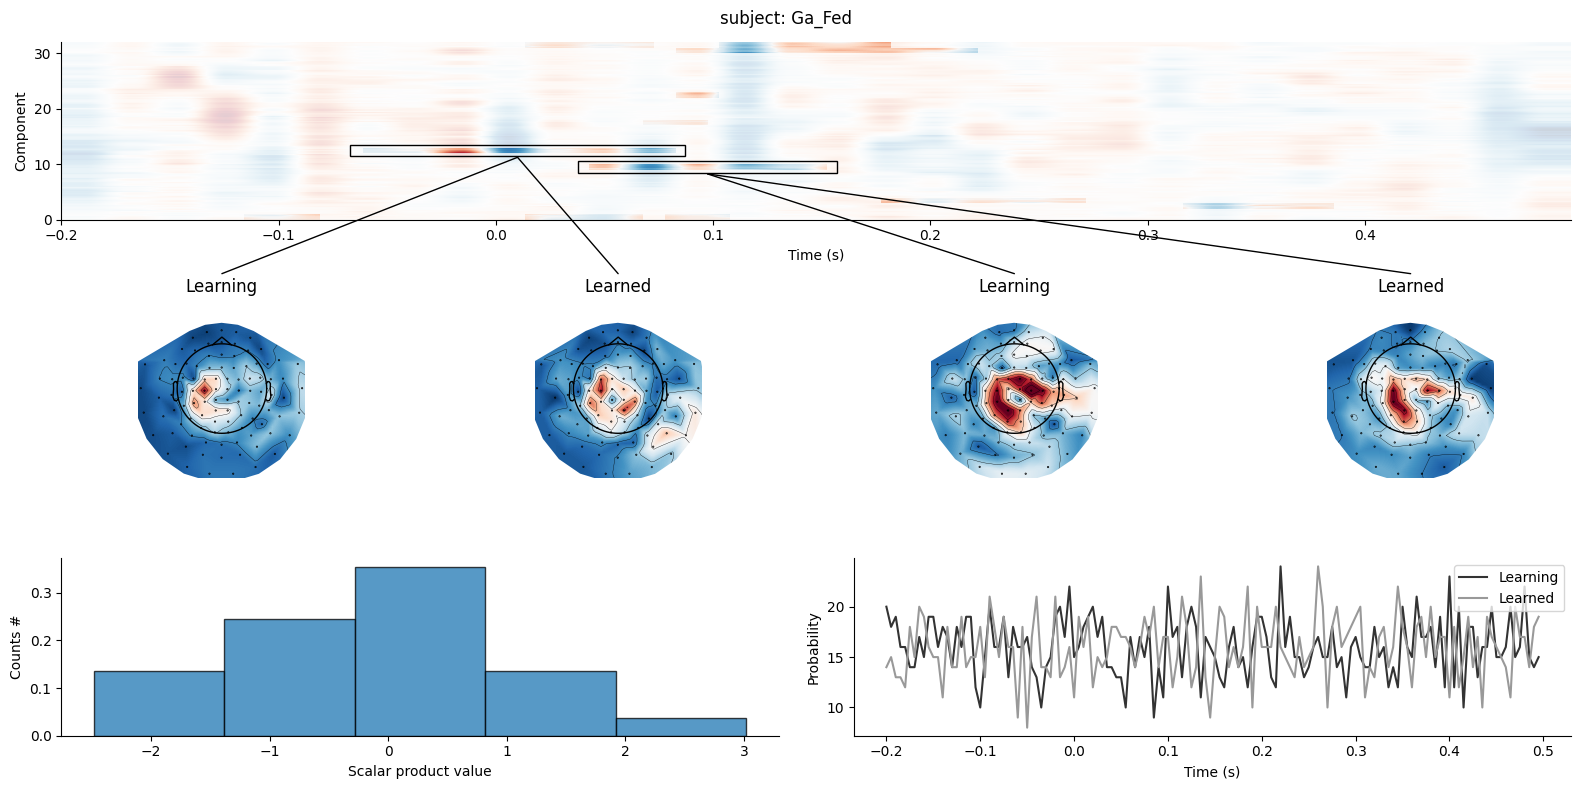

In [45]:
fig = plot_sescomp(
    t_obs,
    times,
    cluster_ranges,
    patterns_data_pair,
    waves_data_pair_np,
    info,
    best_patterns,
    best_pattern_times,
    session1,
    session2,
    subject,
    np.random.normal(0, 1, 100),
    (np.random.randint(0, 2, cluster_ranges.shape).sum(axis=0), np.random.randint(0, 2, cluster_ranges.shape).sum(axis=0))
)
plt.show()